In [1]:
# import the necessary packages
import numpy as np
import canton as ct
from canton import *
import matplotlib.pyplot as plt
# import tensorflow as tf v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
# reduce the log level error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# get the data from cifar
def cifar():
    from keras.datasets import cifar10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255
    return X_train

In [3]:
# ceraate an encoder layer
def encoder():
    c=Can()
    def conv(nip,nop,tail=True):
        c.add(Conv2D(nip,nop,k=3,usebias=True))
        if tail:
            # c.add(BatchNorm(nop))
            c.add(Act('elu'))
    c.add(Lambda(lambda x:x-0.5))
    conv(3,16)
    conv(16,32)
    conv(32,64)
    conv(64,128,tail=False)
    c.chain()
    return c


In [4]:
def decoder():
    c= Can()
    def conv(nip,nop,tail=True):
        c.add(Conv2D(nip,nop,k=3,usebias=True))
        if tail:
            # c.add(BatchNorm(nop))
            c.add(Act('elu'))

    conv(128,64)
    conv(64,32)
    conv(32,16)
    conv(16,3,tail=False)
    c.add(Act('sigmoid'))
    c.chain()
    return c

In [5]:
def get_trainer():
    x = ph([None,None,3])

    # augment the training set by adding random gain and bias pertubation
    sx = tf.shape(x)
    input_gain = tf.random_uniform(
        minval=0.6,
        maxval=1.4,
        shape=[sx[0],1,1,1])
    input_bias = tf.random_uniform(
        minval=-.2,
        maxval=.2,
        shape=[sx[0],1,1,1])
    noisy_x = x * input_gain + input_bias
    noisy_x = tf.clip_by_value(noisy_x,clip_value_max=1.,clip_value_min=0.)

    code_noise = tf.Variable(0.1)
    linear_code = enc(noisy_x)

    # add gaussian before sigmoid to encourage binary code
    noisy_code = linear_code + \
        tf.random_normal(stddev=code_noise,shape=tf.shape(linear_code))
    binary_code = Act('sigmoid')(noisy_code)

    y = dec(binary_code)
    loss = tf.reduce_mean((y-noisy_x)**2) + tf.reduce_mean(binary_code**2) * 0.01

    opt = tf.train.AdamOptimizer()
    train_step = opt.minimize(loss,
        var_list=enc.get_weights()+dec.get_weights())

    def feed(batch,cnoise):
        sess = ct.get_session()
        res = sess.run([train_step,loss],feed_dict={
            x:batch,
            code_noise:cnoise,
        })
        return res[1]

    set_training_state(False)
    quantization_threshold = tf.Variable(0.5)
    binary_code_test = tf.cast(binary_code>quantization_threshold,tf.float32)
    y_test = dec(binary_code_test)

    def test(batch,quanth):
        sess = ct.get_session()
        res = sess.run([binary_code_test,y_test,binary_code,y,noisy_x],feed_dict={
            x:batch,
            quantization_threshold:quanth,
        })
        return res
    return feed,test

In [6]:
def r(ep=1,cnoise=0.1):
    np.random.shuffle(xt)
    length = len(xt)
    bs = 20 #interval second
    for i in range(ep):
        print('ep',i)
        for j in range(0,length,bs):
            minibatch = xt[j:j+bs]
            loss = feed(minibatch,cnoise)
            print(j,'loss:',loss)

            if j%1000==0:
                show()

In [7]:
def show(threshold=.5):
    from cv2tools import vis,filt
    bs = 16
    j = np.random.choice(len(xt)-16)
    minibatch = xt[j:j+bs]
    code, rec, code2, rec2, noisy_x = test(minibatch,threshold)

    code = np.transpose(code[0:1],axes=(3,1,2,0))
    code2 = np.transpose(code2[0:1],axes=(3,1,2,0))

    vis.show_batch_autoscaled(code, name='code(quant)', limit=600.)
    vis.show_batch_autoscaled(code2, name='code2(no quant)', limit=600.)

    vis.show_batch_autoscaled(noisy_x,name='input')
    vis.show_batch_autoscaled(rec,name='recon(quant)')
    vis.show_batch_autoscaled(rec2,name='recon(no quant)')

In [8]:
def save():
    print(enc, "enc")
    enc.save_weights('enc.npy')
    dec.save_weights('dec.npy')

In [9]:
def load():
    enc.load_weights('enc.npy')
    dec.load_weights('dec.npy')

In [10]:
enc,dec = encoder(),decoder()
enc.summary()
dec.summary()
xt = cifar()

-------------------
Directly Trainable:
counting variables...
         3    3    3   16  ->  432    W:0
                       16  ->  16     b:0
         3    3   16   32  ->  4608   W_1:0
                       32  ->  32     b_1:0
         3    3   32   64  ->  18432  W_2:0
                       64  ->  64     b_2:0
         3    3   64  128  ->  73728  W_3:0
                      128  ->  128    b_3:0
               tensors: 8  ->  97440  variables
-------------------
Not Directly Trainable:
counting variables...
               tensors: 0  ->  0      variables
-------------------
-------------------
Directly Trainable:
counting variables...
         3    3  128   64  ->  73728  W_4:0
                       64  ->  64     b_4:0
         3    3   64   32  ->  18432  W_5:0
                       32  ->  32     b_5:0
         3    3   32   16  ->  4608   W_6:0
                       16  ->  16     b_6:0
         3    3   16    3  ->  432    W_7:0
                        3  ->  3      

In [11]:
feed,test = get_trainer()
get_session().run(ct.gvi())

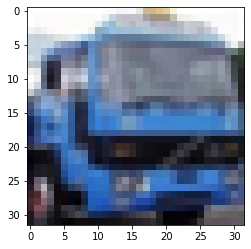

In [12]:
# randomly select input image
index = np.random.randint(len(xt))
# plot the image
plt.imshow(xt[index])
plt.gray()

In [51]:
def showImage(j, threshold=0.8):
    from cv2tools import vis,filt
    bs = 16
    minibatch = xt[j:j+bs]
    code, rec, code2, rec2, noisy_x = test(minibatch,threshold)
    vis.clear()
    vis.show_batch_autoscaled(rec2,name='recon(no quant)')
    image = rec2[15]
    plt.imshow(np.squeeze(image))
    plt.gray()
    # vis.show_batch_autoscaled(rec2,name='recon(no quant)')

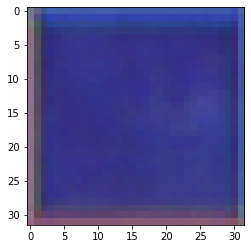

In [53]:
# visualize compressed image
# load()
showImage(index)
# plt.gray()